In [1]:
#Используя transfer-learning

In [1]:
from PIL.Image import BILINEAR
from PIL import Image
import torch
import torchvision
import numpy as np
import pandas as pd
import zipfile
import os
import random
import shutil
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.random.manual_seed(seed)
 

In [3]:
# Извлечение из zip
def extract_data(from_path, to_path = "./data"):
    with zipfile.ZipFile(from_path, 'r') as zip:
        zip.extractall(to_path)

# Для поворота всех изображений в train
def make_extra_data(root_path): 
    suffix = ['_90', '_180', '_270']
    angles = [90, 180, 270]

    for path in root_path:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))

        for file_name in files:
            img = Image.open(path + file_name)
            for suf, angle in enumerate(angles):
                new_img = img.rotate(angle = angle, expand = True)
                img_path = path + file_name[:file_name.find('.')] + suffix[suf] + ".jpg"
                if not os.path.exists(img_path):
                    new_img.save(img_path, 'JPEG')
        
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' in x, files))
        print('{} new files in {}'.format(len(files), path))


# Разделение на train и validation
def create_train_val(max_i = 5):
    for dir_name in [train_dir, val_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

    for class_name in class_names:
        source_dir = os.path.join(root_path, 'train', class_name)
        
        i = 0
        for _, file_name in enumerate(os.listdir(source_dir)):
            if i % max_i != 0:
                dest_dir = os.path.join(train_dir, class_name)
            else:
                dest_dir = os.path.join(val_dir, class_name)
            shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
            i += 1
        
    for fold in ['train', 'val']:
        sum = 0
        for class_name in class_names:
            path = os.path.join(fold, class_name)
            files = os.listdir(path)
            files = list(filter(lambda x: x.endswith('.jpg'), files))
            sum += len(files)
            
        print('{}  files in {}'.format(sum, fold))



# Создание папки с тестовой выборкой
def create_test():
    src = os.path.join(root_path, 'test')
    out = os.path.join(test_dir, 'unknown')
    if not os.path.exists(out):
        shutil.copytree(src, out)

    files = os.listdir(out)
    files = list(filter(lambda x: x.endswith('.jpg'), files))
    print("{} files in Test".format(len(files)))

In [4]:
root_path = ".\\data\\plates"
train_dir = "train"
val_dir = 'val'
test_dir = 'test'
class_names = ["cleaned", "dirty"]

extract_data(r'D:\Programming\CNN\Cleaned_vs_Dirty\input\plates.zip')

# make_extra_data([
#     os.path.join(root_path, train_dir, "cleaned\\"),
#     os.path.join(root_path, train_dir, "dirty\\")
# ])
create_train_val(5)
create_test()

32  files in train
8  files in val
744 files in Test


In [5]:
# Перемешивание RGB каналов в тензоре
class RGBShuffleInTensor(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img_tensor):
        if self.p < random.random():
            return img_tensor
        indices = np.random.permutation(3)
        # print(indices)
        img_tensor[:] = img_tensor[indices]
        return img_tensor

In [6]:
from torchvision import transforms
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.CenterCrop(224),
        transforms.RandomResizedCrop(224)
    ]),
    transforms.RandomVerticalFlip(),
    # transforms.Resize((224,224)),
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(45, resample=BILINEAR),
    ]),
    
    transforms.RandomPerspective(p = 0.1, distortion_scale=0.1),
    transforms.ColorJitter(0.25, 0.25, 0.25, 0.25),
    transforms.ToTensor(),
    RGBShuffleInTensor(0.3),
    transforms.Normalize(norm_mean, norm_std)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

In [7]:
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [8]:
len(train_dataloader), len(train_dataset)

(4, 32)

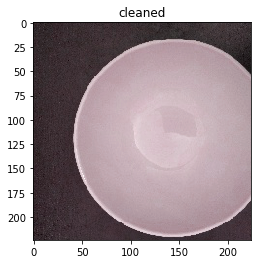

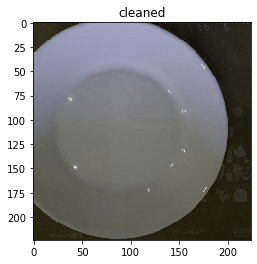

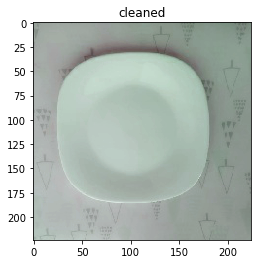

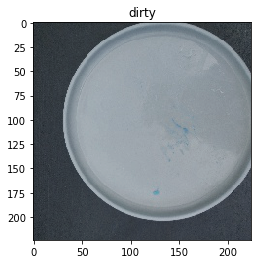

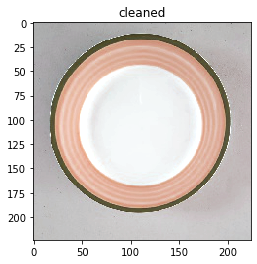

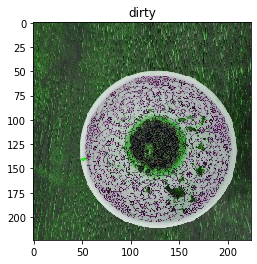

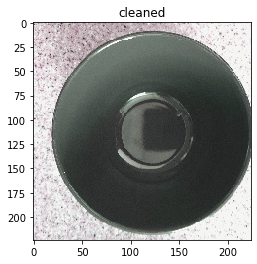

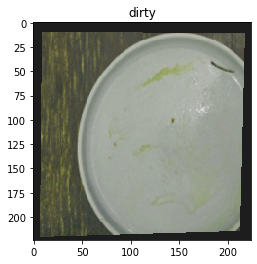

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = norm_std * image + norm_mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

iterator = iter(train_dataloader)
X_batch, y_batch = next(iterator)
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [10]:
device = "cuda:0" if torch.cuda.is_available() else 'cpu'

In [11]:
def train_model(model, loss_func, optimizer, max_epochs = 50, scheduler=None):
    acc_history = []
    loss_history = []
    print('Train on {}'.format(device.upper()))

    for epoch in range(max_epochs):
        print("Epoch {}/{}".format(epoch, max_epochs -1))

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()
            else:
                model.eval()
                dataloader = val_dataloader
            
            running_loss = 0.
            running_acc = 0.

            for inputs, labels in dataloader:
                optimizer.zero_grad()

                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss = loss_func(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step()
                
                running_loss += loss.item()
                running_acc += (preds_class == labels.data).float().mean()

                del inputs
                del labels
            
            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            print('{} Loss: {:.3f} Acc: {:.3f}'.format(phase, epoch_loss, epoch_acc))

            if (phase == 'val'):
                acc_history.append(epoch_acc)
                loss_history.append(epoch_loss)
        print()
    return model, loss_history, acc_history


In [12]:
class MyModel(torch.nn.Module):
    def __init__(self, complex = True):
        super(MyModel, self).__init__()
        self.net = torchvision.models.resnet18(pretrained=True)

        for param in self.net.parameters():
            param.requires_grad = False
        
        in_features = self.net.fc.in_features

        if complex is True:
            new_fc = torch.nn.Sequential(
                # torch.nn.Dropout(0.1),
                torch.nn.Linear(in_features, 256),
                torch.nn.SELU(),
                torch.nn.Linear(256, 128),
                torch.nn.Sigmoid(),
                torch.nn.Linear(128, 2)
            )
        else:   
            new_fc = torch.nn.Sequential(
                torch.nn.Linear(in_features, 2)
            )
        self.net.fc = new_fc

    def forward(self, x):
        x = self.net(x)
        return x

In [13]:
set_seed(0)

# model = MyModel()
# model = model.to(device)

loss_func = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.7, lr=0.001)
# optimizer = torch.optim.RMSprop(model.parameters())

def get_optimizer(name, model):
    if name == 'Adam':
        return torch.optim.Adam(model.parameters(), lr=0.001)
    if name == 'SGD_0.7':
        return torch.optim.SGD(model.parameters(), momentum=0.7, lr=0.001)
    if name == 'SGD':
        return torch.optim.SGD(model.parameters(), lr = 0.001)
    if name == 'Rprop':
        return torch.optim.Rprop(model.parameters())

optimizers = ['Adam', 'SGD_0.7', 'SGD', 'Rprop']
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [14]:
accuracies = {}
losses = {}

for complex in [True, False]:
    for opt in optimizers:
        set_seed(0)
        model = MyModel(complex)
        model = model.to(device)
        optimizer = get_optimizer(opt, model)
        if opt != 'RMSprop':
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        else:
            scheduler = None
        print('\n{} {}'.format(complex, opt))
        model, loss, acc = train_model(model, loss_func, optimizer, scheduler=scheduler, max_epochs=30)
        accuracies['{}_{}'.format(complex, opt)] = acc
        losses['{}_{}'.format(complex, opt)] = loss
        torch.save(model, '{}_{}_2.pt'.format(complex, opt))
        
        del model
        del optimizer
        del scheduler


True Adam
Train on CUDA:0
Epoch 0/29
train Loss: 0.723 Acc: 0.500
val Loss: 0.631 Acc: 1.000

Epoch 1/29
train Loss: 0.893 Acc: 0.469
val Loss: 0.775 Acc: 0.500

Epoch 2/29
train Loss: 0.751 Acc: 0.594
val Loss: 0.628 Acc: 0.500

Epoch 3/29
train Loss: 0.631 Acc: 0.781
val Loss: 0.624 Acc: 0.875

Epoch 4/29
train Loss: 0.620 Acc: 0.812
val Loss: 0.619 Acc: 1.000

Epoch 5/29
train Loss: 0.626 Acc: 0.844
val Loss: 0.616 Acc: 1.000

Epoch 6/29
train Loss: 0.627 Acc: 0.844
val Loss: 0.616 Acc: 1.000

Epoch 7/29
train Loss: 0.635 Acc: 0.812
val Loss: 0.615 Acc: 1.000

Epoch 8/29
train Loss: 0.636 Acc: 0.812
val Loss: 0.615 Acc: 1.000

Epoch 9/29
train Loss: 0.653 Acc: 0.781
val Loss: 0.615 Acc: 1.000

Epoch 10/29
train Loss: 0.621 Acc: 0.844
val Loss: 0.619 Acc: 1.000

Epoch 11/29
train Loss: 0.631 Acc: 0.781
val Loss: 0.619 Acc: 1.000

Epoch 12/29
train Loss: 0.612 Acc: 0.938
val Loss: 0.618 Acc: 1.000

Epoch 13/29
train Loss: 0.649 Acc: 0.781
val Loss: 0.615 Acc: 1.000

Epoch 14/29
train

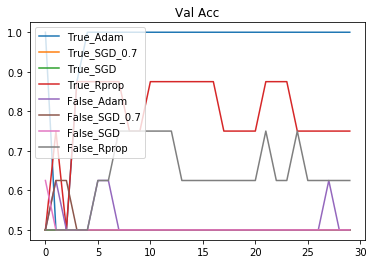

In [15]:
for i, val in accuracies.items():
    plt.plot(val, label=i)
plt.legend()
plt.title('Val Acc');


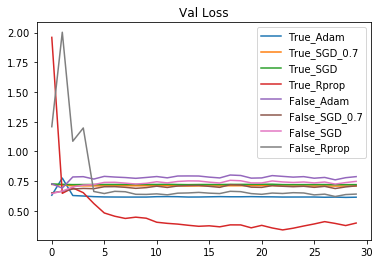

In [16]:
for i, val in losses.items():
    plt.plot(val, label=i)
plt.legend()
plt.title('Val Loss');

In [18]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [40]:
# model = torch.load('True_Adam_2.pt')
model = torch.load('True_Rprop_2.pt')
model = model.to(device)
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in (test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

In [41]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df.head()

id     label
0  test\unknown\0000.jpg  0.883009
1  test\unknown\0001.jpg  0.784944
2  test\unknown\0002.jpg  0.859069
3  test\unknown\0003.jpg  0.883566
4  test\unknown\0004.jpg  0.784304

In [42]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace(r'test\\unknown\\', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id         
0000  dirty
0001  dirty
0002  dirty
0003  dirty
0004  dirty
0005  dirty

In [43]:
submission_df[submission_df['label'] == 'cleaned']

label
id           
0012  cleaned
0014  cleaned
0024  cleaned
0027  cleaned
0028  cleaned
...       ...
0720  cleaned
0731  cleaned
0737  cleaned
0741  cleaned
0743  cleaned

[178 rows x 1 columns]

In [39]:
submission_df.to_csv('submission.csv')

На тесте Adam оптимизация показала результат немного хуже (~0.82).  
Score полученный при Rprop

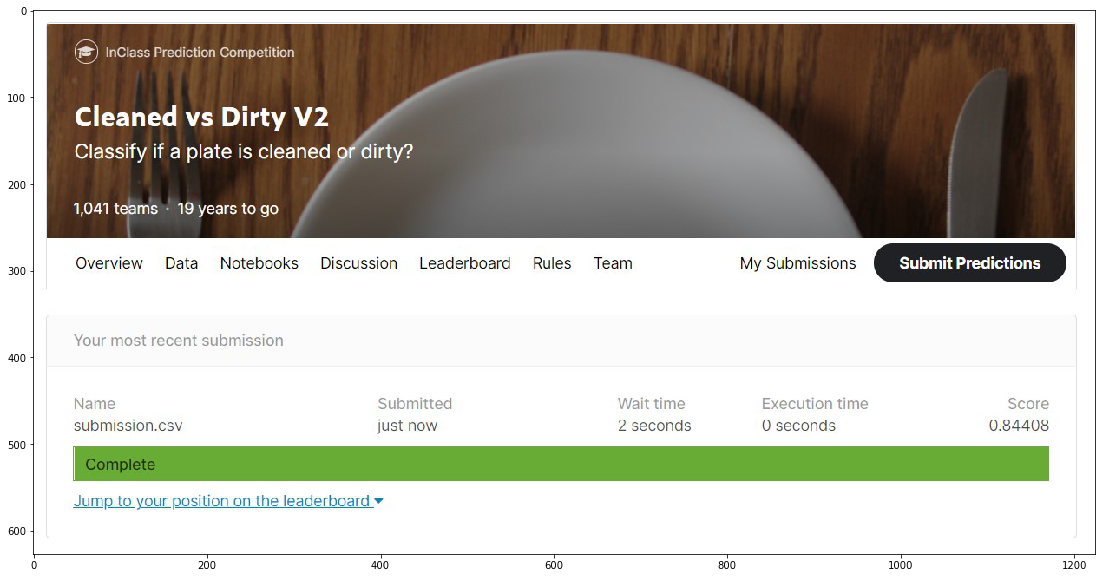

In [51]:
img = Image.open("Screenshot_3.jpg")
plt.figure(figsize = (20, 10))
plt.imshow(img)
plt.show()

In [33]:
iterator = iter(test_dataloader)

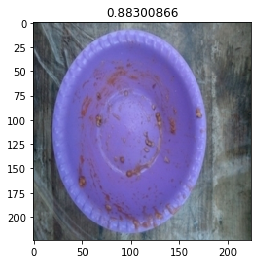

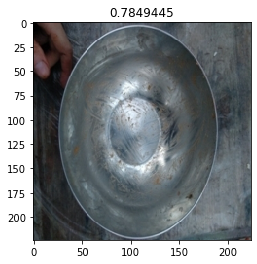

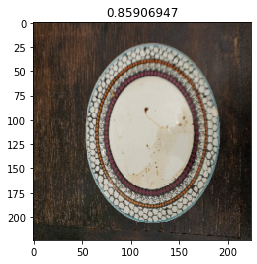

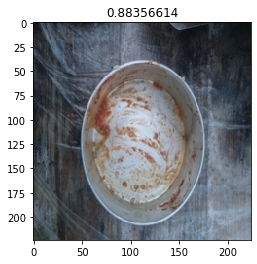

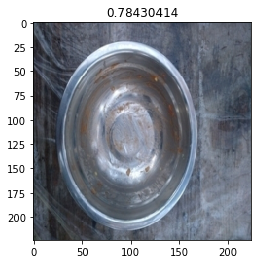

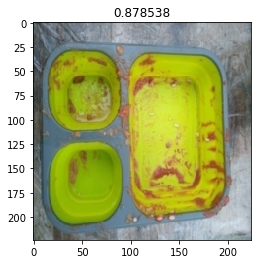

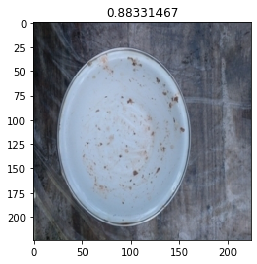

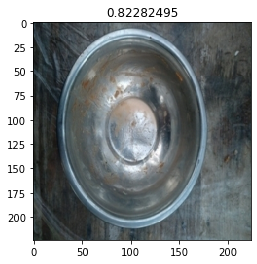

In [34]:
inputs, labels, paths = next(iterator)

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)